In [192]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

from importlib import reload
import encasm.env
reload(encasm.env)
from encasm.env import PetriDish

import utils.videowriter
reload(utils.videowriter)
from utils.videowriter import VideoWriter
import encasm
reload(encasm)
import encasm.eval
reload(encasm.eval)
from encasm.eval import load_tests

data_dir = "./encasm/example_networks/"
test_envs = load_tests(folder = data_dir)

import encasm.env
reload(encasm.env)
from encasm.env import PetriDish


In [193]:
test_env = PetriDish.from_config_file("test", "./encasm/configs/default_config.ini")

In [195]:
test_envs['large']['7']['1']

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [282]:
# applies a 2d convolution to the grid using scipy and the given kernel
def convolve(grid, kernel):
    return signal.convolve2d(grid, kernel, mode='same', boundary='fill', fillvalue=0)

def diffuse(r,l, cutoff=0.5):
    l = l>0 # convert to boolean in case it isn't

    kernel = np.array([[0,1,0],[1,0,1],[0,1,0]], dtype=np.float32)
    ksum = np.sum(kernel)

    # plt.matshow(r)
    # plt.colorbar()
    # print(r.sum())
    free_cells = (r<cutoff) & l # A free cell is alive and isn't full of nutrients
    sources = r >= cutoff # purely cells that are full

    # How large of an area could a cell's resevoir flow to
    flow_area = convolve(free_cells, kernel) * l
    flow_area[l] += 1 # every cell includes itself

    # Nonzero just avoids divide by zero, this is just 5/flow_area * r, which is the adjusted nutrients 
    # to "bounce back" diffusion off of full cells and voids
    to_diff = np.divide(ksum, flow_area, out=np.zeros_like(r), where=flow_area!=0) * r

    kernel[1,1] = 1
    kernel *= (1./ksum)
    sinks = convolve(to_diff, kernel) * free_cells # sinks serve as sources to other sinks too


    # creates an array where free_cells have the value of sinks and sources have the value of to_diff * 0.2
    diffused = np.zeros_like(r)
    diffused[free_cells] = sinks[free_cells]
    diffused[sources] = to_diff[sources] * (1./ksum)
    # plt.matshow(diffused)
    # plt.colorbar()
    # print(diffused.sum())
    return diffused

# tenv = PetriDish.from_env("tenv", test_envs["small"]['3']['1'])
# tenv.resv += tenv.food

# an 8 by 8 array representing an elbow bend road of life
# l = np.array([[0,1,1],
#               [0,1,1],
#               [0,1,0]], dtype=np.float32)
# r = np.array([[0,1,1],
#               [0,1,0],
#               [0,0,0]], dtype=np.float32)

# # diffuses 10 times and shows makes a video
# with VideoWriter(filename="./encasm/results/diffusion.mp4", fps=100) as vw:
#     for i in range(100):
#         tmp = r
#         r = diffuse(r,l)
#         vw.add_concat_grids([r,l], cols=2)
#         if r.sum() != 3:
#             display(r.sum(),  tmp.sum(), tmp)

441.0

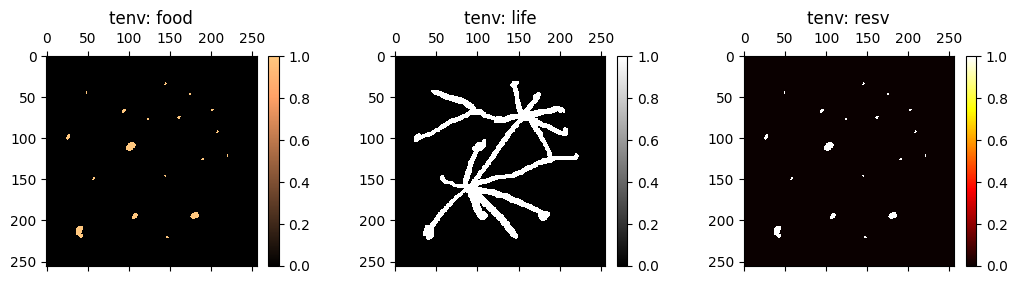

In [271]:
tenv = PetriDish.from_env("tenv", test_envs["large"]['6']['3'])

tenv.resv += tenv.food
tenv.display()
tenv.resv.sum()


In [274]:
tenv.life = np.ones_like(tenv.life)

In [289]:
import math
diffs = []
# Records a video of diffusion in tenv
with VideoWriter("./encasm/results/diffusion.mp4", fps=15) as vid:

    for i in range(250):
        tenv.resv += tenv.food * 0.2
        tenv.resv = np.clip(tenv.resv, 0, 4)
        presv = tenv.resv
        tenv.resv = diffuse(tenv.resv, tenv.life, cutoff=1.3)

        # diffs.append(tenv.resv[11,13])
        # tenv.resv[11,13] = 0
        # diffs.append(tenv.resv[21,10])
        # tenv.resv[21,10] = 0

        if i % 1 == 0:
            tenv.resv[0,0] = 3
            tenv.resv[0,1] = 0
            vid.add_concat_grids([tenv.resv], cmaps=["viridis"], cols = 1)
diffs = np.array(diffs)

87936.052312345


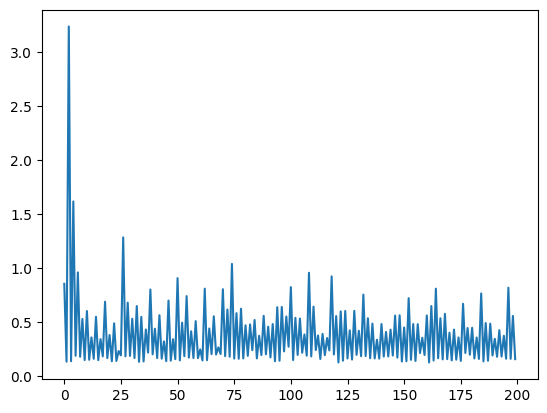

In [253]:
# plots diffs
plt.plot(diffs)

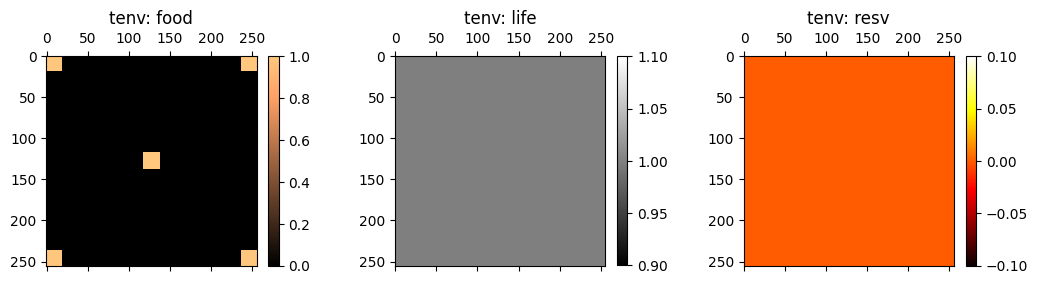

In [189]:
tenv.food = np.zeros_like(tenv.life)
tenv.life = np.ones_like(tenv.life)
# places blocks of food the size of sz in the corners and middle of a the food grid
sz=20
tenv.food[:sz,:sz] = 1
tenv.food[-sz:,-sz:] = 1
tenv.food[-sz:,:sz] = 1
tenv.food[:sz,-sz:] = 1
tenv.food[tenv.food.shape[0]//2-sz//2:tenv.food.shape[0]//2+sz//2,tenv.food.shape[1]//2-sz//2:tenv.food.shape[1]//2+sz//2] = 1


tenv.display()

In [196]:
from PIL import Image
# saves an image of tenv food
Image.fromarray(tenv.food).save("./encasm/results/food.png")
# saves an image of tenv life in example large

OSError: cannot write mode F as PNG